In [1]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
import numpy as np
from tensorflow.contrib.slim import fully_connected as fc
import time
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

In [2]:
import struct
from functools import singledispatch

from keras.layers import (
    Dense,
    Conv1D, Conv2D,
    LocallyConnected1D, LocallyConnected2D,
    Flatten,
    ELU,
    Activation,
    MaxPooling2D,
    LSTM,
    Embedding,
    BatchNormalization,
    )

LAYERS = (
    Dense,
    Conv1D, Conv2D,
    LocallyConnected1D, LocallyConnected2D,
    Flatten,
    ELU,
    Activation,
    MaxPooling2D,
    LSTM,
    Embedding,
    BatchNormalization,
)

ACTIVATIONS = (
    'linear',
    'relu',
    'elu',
    'softplus',
    'softsign',
    'sigmoid',
    'tanh',
    'hard_sigmoid',
    'softmax',
)


def write_tensor(f, data, dims=1):
    """
    Writes tensor as flat array of floats to file in 1024 chunks,
    prevents memory explosion writing very large arrays to disk
    when calling struct.pack().
    """
    for stride in data.shape[:dims]:
        f.write(struct.pack('I', stride))

    data = data.flatten()
    step = 1024
    written = 0

    for i in np.arange(0, len(data), step):
        remaining = min(len(data) - i, step)
        written += remaining
        f.write(struct.pack(f'={remaining}f', *data[i: i + remaining]))

    assert written == len(data)


def export_activation(activation, f):
    try:
        f.write(struct.pack('I', ACTIVATIONS.index(activation) + 1))
    except ValueError as exc:
        raise NotImplementedError(activation) from exc


@singledispatch
def export(layer, _):
    raise NotImplementedError(layer)


@export.register(Flatten)
def _(_0, _1):
    pass


@export.register(Activation)
def _(layer, f):
    activation = layer.get_config()['activation']
    export_activation(activation, f)


@export.register(ELU)
def _(layer, f):
    f.write(struct.pack('f', layer.alpha))


@export.register(BatchNormalization)
def _(layer, f):
    epsilon = layer.epsilon
    gamma = layer.get_weights()[0]
    beta = layer.get_weights()[1]
    pop_mean = layer.get_weights()[2]
    pop_variance = layer.get_weights()[3]

    weights = gamma / np.sqrt(pop_variance + epsilon)
    biases = beta - pop_mean * weights

    write_tensor(f, weights)
    write_tensor(f, biases)


@export.register(Dense)
def _(layer, f):
    # shape: (outputs, dims)
    weights = layer.get_weights()[0].transpose()
    biases = layer.get_weights()[1]
    activation = layer.get_config()['activation']

    write_tensor(f, weights, 2)
    write_tensor(f, biases)
    export_activation(activation, f)


@export.register(Conv1D)
def _(layer, f):
    # shape: (outputs, steps, dims)
    weights = layer.get_weights()[0].transpose(2, 0, 1)
    biases = layer.get_weights()[1]
    activation = layer.get_config()['activation']

    write_tensor(f, weights, 3)
    write_tensor(f, biases)
    export_activation(activation, f)


@export.register(Conv2D)
def _(layer, f):
    # shape: (outputs, rows, cols, depth)
    weights = layer.get_weights()[0].transpose(3, 0, 1, 2)
    biases = layer.get_weights()[1]
    activation = layer.get_config()['activation']

    write_tensor(f, weights, 4)
    write_tensor(f, biases)
    export_activation(activation, f)


@export.register(LocallyConnected1D)
def _(layer, f):
    # shape: (new_steps, outputs, ksize*dims)
    weights = layer.get_weights()[0].transpose(0, 2, 1)
    biases = layer.get_weights()[1]
    activation = layer.get_config()['activation']

    write_tensor(f, weights, 3)
    write_tensor(f, biases, 2)
    export_activation(activation, f)


@export.register(LocallyConnected2D)
def _(layer, f):
    # shape: (rows*cols, outputs, ksize*depth)
    weights = layer.get_weights()[0]
    # weights = weights.transpose(0, 2, 1)
    biases = layer.get_weights()[1]
    activation = layer.get_config()['activation']

    write_tensor(f, weights, 3)
    write_tensor(f, biases, 2)
    export_activation(activation, f)


@export.register(MaxPooling2D)
def _(layer, f):
    pool_size = layer.get_config()['pool_size']

    f.write(struct.pack('I', pool_size[0]))
    f.write(struct.pack('I', pool_size[1]))


@export.register(LSTM)
def _(layer, f):
    inner_activation = layer.get_config()['recurrent_activation']
    activation = layer.get_config()['activation']
    return_sequences = int(layer.get_config()['return_sequences'])

    weights = layer.get_weights()
    units = layer.units

    kernel, rkernel, bias = ([x[i: i+units] for i in range(0, 4*units, units)]
                             for x in (weights[0].transpose(),
                                       weights[1].transpose(),
                                       weights[2]))
    bias = [x.reshape(1, -1) for x in bias]
    for tensors in zip(kernel, rkernel, bias):
        for tensor in tensors:
            write_tensor(f, tensor, 2)

    export_activation(inner_activation, f)
    export_activation(activation, f)
    f.write(struct.pack('I', return_sequences))


@export.register(Embedding)
def _(layer, f):
    weights = layer.get_weights()[0]
    write_tensor(f, weights, 2)


def export_model(model, filename):
    with open(filename, 'wb') as f:
        layers = [layer for layer in model.layers
                  if type(layer).__name__ not in ['Dropout']]
        f.write(struct.pack('I', len(layers)))

        for layer in layers:
            f.write(struct.pack('I', LAYERS.index(type(layer)) + 1))
            export(layer, f)

Using TensorFlow backend.


In [3]:
df1_ori = pd.read_pickle('/Users/mingfei/Softwares/KNN2/prod/random_config/256Atoms/encode_save.pd')

In [4]:
df1_ori

,1,3,4,5,6,7,8,9,10,11,...,type_x,hash,conc_y,config,neb,E_barr,initE,finalE,type_y,E_diff
0,0,0,Al,Al,Al,Al,Al,Zn,Al,Al,...,f,239_6_7_4_0_0_f,239_6_7_4,0,0,0.573696,-909.374360,-909.371037,f,0.003323
1,0,0,Al,Al,Al,Al,Al,Al,Zn,Al,...,f,239_6_7_4_0_0_f,239_6_7_4,0,0,0.573696,-909.374360,-909.371037,f,0.003323
2,0,0,Al,Al,Al,Al,Al,Al,Al,Zn,...,f,239_6_7_4_0_0_f,239_6_7_4,0,0,0.573696,-909.374360,-909.371037,f,0.003323
3,0,0,Al,Al,Al,Al,Zn,Al,Al,Al,...,f,239_6_7_4_0_0_f,239_6_7_4,0,0,0.573696,-909.374360,-909.371037,f,0.003323
4,0,1,Al,Al,Al,Al,X,Al,Al,Al,...,f,239_6_7_4_0_1_f,239_6_7_4,0,1,0.539438,-909.374360,-909.431278,f,-0.056919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3059,9,3,Al,Al,Al,Al,Al,Al,Al,Al,...,b,242_6_6_2_9_3_b,242_6_6_2,9,3,0.536978,-921.113738,-921.085453,b,-0.028285
3060,9,4,Al,Al,Al,Zn,Al,Al,Al,Zn,...,b,242_6_6_2_9_4_b,242_6_6_2,9,4,0.593086,-921.113738,-921.185219,b,0.071481
3061,9,4,Al,Al,Zn,Al,Zn,Al,Al,Al,...,b,242_6_6_2_9_4_b,242_6_6_2,9,4,0.593086,-921.113738,-921.185219,b,0.071481
3062,9,4,Al,Al,Zn,Al,Al,Zn,Al,Al,...,b,242_6_6_2_9_4_b,242_6_6_2,9,4,0.593086,-921.113738,-921.185219,b,0.071481


In [5]:
N_old = 2500
df1_ori = df1_ori.sample(frac=1)
df1 = df1_ori.head(N_old)
df2 = pd.read_pickle('/Users/mingfei/Softwares/KNN2/prod/uniform/Mg/encode_save.pd')
df3 = pd.read_pickle('/Users/mingfei/Softwares/KNN2/prod/uniform/Zn/encode_save.pd')
df4 = pd.read_pickle('/Users/mingfei/Softwares/KNN2/prod/uniform/Mg_Zn/encode_save.pd')
df5 = pd.read_pickle('/Users/mingfei/Softwares/KNN2/prod/uniform/Zn_2/encode_save.pd')
df6 = pd.read_pickle('/Users/mingfei/Softwares/KNN2/prod/uniform/Mg_no_Zn_1/encode_save.pd')
df7 = pd.read_pickle('/Users/mingfei/Softwares/KNN2/prod/uniform/Zn_no_Mg_1/encode_save.pd')

df8 = pd.read_pickle('/Users/mingfei/Softwares/KNN2/prod/ordered_1/encode_save.pd')

In [6]:
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8], ignore_index=True)
df

/Users/mingfei/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,1,3,4,5,6,7,8,9,10,11,...,type_x,hash,conc_y,config,neb,E_barr,initE,finalE,type_y,E_diff
0,4,2,Al,Al,Al,Zn,Al,Al,Al,Al,...,f,242_6_5_3_4_2_f,242_6_5_3,4,2,0.549305,-918.993098,-919.007023,f,-0.013925
1,7,3,Al,Al,Al,Al,Al,Al,Al,Al,...,b,239_6_7_4_7_3_b,239_6_7_4,7,3,0.554635,-909.351928,-909.292860,b,-0.059069
2,5,3,Al,Al,Al,Al,Al,Al,Al,Al,...,b,240_8_5_3_5_3_b,240_8_5_3,5,3,0.599906,-914.432424,-914.437141,b,0.004717
3,6,4,Al,Al,Al,Al,Al,Al,Al,Al,...,f,240_8_5_3_6_4_f,240_8_5_3,6,4,0.487151,-914.435773,-914.449398,f,-0.013625
4,1,3,Al,Al,Al,Al,Al,Al,Al,Al,...,b,239_8_5_4_1_3_b,239_8_5_4,1,3,0.614448,-910.170553,-910.066832,b,-0.103721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11335,62,2,Al,Al,Al,Al,Al,Al,Al,Al,...,b,62_2_b,NaN,62,2,0.285469,-801.784891,-801.581643,b,-0.203248
11336,62,3,Zn,Al,Al,Zn,Al,Al,Al,Zn,...,b,62_3_b,NaN,62,3,0.417075,-801.784891,-801.713085,b,-0.071806
11337,62,3,Zn,Zn,Al,Al,Zn,Al,Al,Al,...,b,62_3_b,NaN,62,3,0.417075,-801.784891,-801.713085,b,-0.071806
11338,62,3,Zn,Zn,Al,Al,Al,Zn,Al,Al,...,b,62_3_b,NaN,62,3,0.417075,-801.784891,-801.713085,b,-0.071806


In [7]:
# df = df[df["type_x"] == "f"]

In [8]:
# def get_conc(row, i):
#     concs = row['conc_y'].split("_")
#     return float(concs[i]) / 256.0
# df['Al_conc'] = df.apply(lambda row : get_conc(row, 0), axis=1)
# df['Mg_conc'] = df.apply(lambda row : get_conc(row, 1), axis=1)
# df['Zn_conc'] = df.apply(lambda row : get_conc(row, 2), axis=1)
# df['Vac_conc'] = df.apply(lambda row : get_conc(row, 3), axis=1)
# df

In [9]:
Ntrain = 8000
lower, upper = 0.005, 1.2 # 0.001, 1.4

In [63]:
data = df.copy()
encodingSchema = {"Al": 1.0, "Mg": 2.0, "Zn": 3.0, "X": 4.0}

def getOneHotEncoding(row):
  res = []
#   res.append(row["Al_conc"])
#   res.append(row["Mg_conc"])
#   res.append(row["Zn_conc"])
#   res.append(row["Vac_conc"])

  tmpCol = range(4, 31)

  for i in tmpCol:
    if row[i] == 'Al':
      res.append(1.0)
    elif row[i] == 'Mg':
      res.append(2.0)
    elif row[i] == 'Zn':
      res.append(3.0)
    elif row[i] == 'X':
      res.append(4.0)
    else:
      res.append(-1.0)
  return np.array(res)
    

data['encode'] = data.apply (lambda row: getOneHotEncoding(row), axis=1)
data = data[["conc_y", "config","neb", "encode", "E_barr", "E_diff"]]

In [64]:
data

,conc_y,config,neb,encode,E_barr,E_diff
0,242_6_5_3,4,2,"[1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.549305,-0.013925
1,239_6_7_4,7,3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.554635,-0.059069
2,240_8_5_3,5,3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.599906,0.004717
3,240_8_5_3,6,4,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.487151,-0.013625
4,239_8_5_4,1,3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.614448,-0.103721
...,...,...,...,...,...,...
11335,NaN,62,2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.285469,-0.203248
11336,NaN,62,3,"[3.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 3.0, 1.0, ...",0.417075,-0.071806
11337,NaN,62,3,"[3.0, 3.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 3.0, ...",0.417075,-0.071806
11338,NaN,62,3,"[3.0, 3.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 3.0, ...",0.417075,-0.071806


In [65]:
tmp = np.array(data["E_barr"]).reshape(-1, 1)
# print(sum(float(num) <= .001 for num in tmp))
data = data[data['E_barr'] > lower]
data = data[data['E_barr'] < upper]
tmp = np.array(data["E_barr"]).reshape(-1, 1)
# print(sum(float(num) <= .0001 for num in tmp))

In [66]:
data

,conc_y,config,neb,encode,E_barr,E_diff
0,242_6_5_3,4,2,"[1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.549305,-0.013925
1,239_6_7_4,7,3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.554635,-0.059069
2,240_8_5_3,5,3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.599906,0.004717
3,240_8_5_3,6,4,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.487151,-0.013625
4,239_8_5_4,1,3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.614448,-0.103721
...,...,...,...,...,...,...
11335,NaN,62,2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.285469,-0.203248
11336,NaN,62,3,"[3.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 3.0, 1.0, ...",0.417075,-0.071806
11337,NaN,62,3,"[3.0, 3.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 3.0, ...",0.417075,-0.071806
11338,NaN,62,3,"[3.0, 3.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 3.0, ...",0.417075,-0.071806


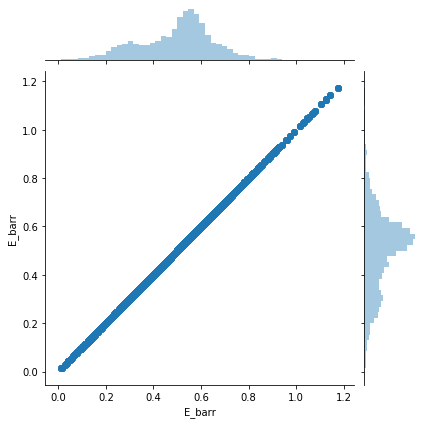

In [67]:
sns_plot = sns.jointplot(x="E_barr", y="E_barr", data=data)

In [68]:
data

,conc_y,config,neb,encode,E_barr,E_diff
0,242_6_5_3,4,2,"[1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.549305,-0.013925
1,239_6_7_4,7,3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.554635,-0.059069
2,240_8_5_3,5,3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.599906,0.004717
3,240_8_5_3,6,4,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.487151,-0.013625
4,239_8_5_4,1,3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.614448,-0.103721
...,...,...,...,...,...,...
11335,NaN,62,2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.285469,-0.203248
11336,NaN,62,3,"[3.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 3.0, 1.0, ...",0.417075,-0.071806
11337,NaN,62,3,"[3.0, 3.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 3.0, ...",0.417075,-0.071806
11338,NaN,62,3,"[3.0, 3.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 3.0, ...",0.417075,-0.071806


<Figure size 432x288 with 0 Axes>

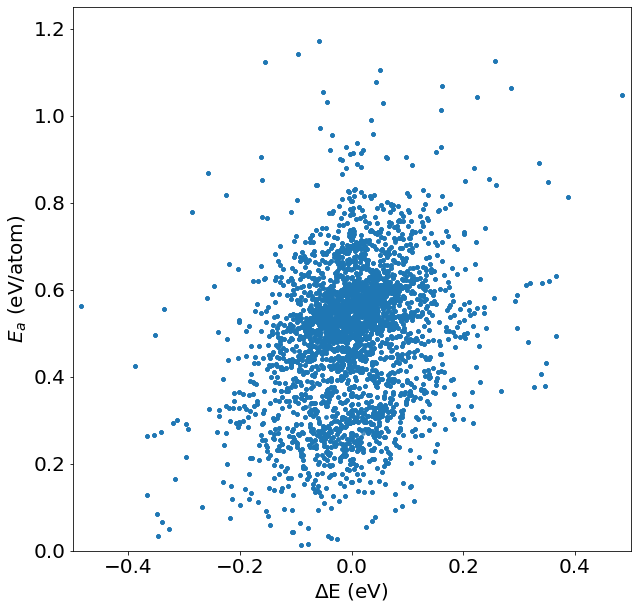

In [88]:
plt.figure()
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(data["E_diff"], data["E_barr"], marker='o', linestyle='', ms=3.5, alpha=0.75, label="total "+str(len(y_test))+" test cases")
plt.xlim([-0.5, 0.5])
plt.ylim([0.0, 1.25])
plt.xlabel("$\Delta$E (eV)", size=20)
plt.ylabel("$E_a$ (eV/atom)", size=20)
ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig("E-EB.pdf")

In [16]:
def getStr(row):
  tmpCol = range(4, 31)
  res = ""
  for i in range(len(row["encode"])):
    res+=str(row["encode"][i])
  return res

data['encode_hash'] = data.apply (lambda row: getStr(row), axis=1)

In [17]:
# data_hash = data.groupby(['encode_hash'])
# data_hash.describe()

In [18]:
# # data_hash
# for name, group in data_hash:
#     if (group.E_barr.count() > 1):
#         print(name, group.E_barr.count(), group.E_barr.mean(), group.E_barr.std())

In [19]:
data = data.drop_duplicates(subset='encode_hash')
data.describe()

,config,neb,E_barr
count,8494.000000,8494.000000,8494.000000
mean,6.977278,1.889569,0.482607
std,14.144045,1.419632,0.173298
min,0.000000,0.000000,0.014732
25%,0.000000,1.000000,0.357278
50%,1.000000,2.000000,0.500415
75%,3.000000,3.000000,0.593114
max,62.000000,6.000000,1.173059


In [20]:
df_ver = df1_ori[N_old:]

# df_ver['Al_conc'] = df_ver.apply(lambda row : get_conc(row, 0), axis=1)
# df_ver['Mg_conc'] = df_ver.apply(lambda row : get_conc(row, 1), axis=1)
# df_ver['Zn_conc'] = df_ver.apply(lambda row : get_conc(row, 2), axis=1)
# df_ver['Vac_conc'] = df_ver.apply(lambda row : get_conc(row, 3), axis=1)

df_ver['encode'] = df_ver.apply (lambda row: getOneHotEncoding(row), axis=1)
df_ver = df_ver[["conc_y", "config","neb", "encode", "E_barr"]]

df_ver = df_ver[df_ver['E_barr'] > lower]
df_ver = df_ver[df_ver['E_barr'] < upper]
# df_ver['encode_hash'] = df_ver.apply (lambda row: getStr(row), axis=1)
# df_ver = df_ver.drop_duplicates(subset='encode_hash')
x_ver, y_ver = np.stack(df_ver["encode"]), np.array(df_ver["E_barr"]).reshape(-1, 1)

/Users/mingfei/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
x, y = np.stack(data["encode"]), np.array(data["E_barr"]).reshape(-1, 1)
# x, y = np.stack(data["encode"]), np.array(data["log_E_barr"]).reshape(-1, 1)


np.savez("/Users/mingfei/Softwares/KNN2/prod/training.npz", x=x, y=y)

# scaler = StandardScaler()
# scaler.fit(y)
# y = scaler.transform(y)

x, y = shuffle(x, y, random_state=0)

x_train, y_train = x[:Ntrain], y[:Ntrain]
x_test, y_test = x[Ntrain:], y[Ntrain:]
# x_test = np.vstack((x_test, x_ver))
# y_test = np.vstack((y_test, y_ver))

In [22]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils
from keras import optimizers
from keras import backend as K

In [23]:
def get_model():
    
    def customLoss(yTrue, yPred):
#         return keras.losses.mean_squared_error(yTrue, yPred) * (1.0 + 10.0 * abs(yTrue - 0.55))
        return K.mean(((yTrue-yPred)*(yTrue-yPred) * (1.0 + 10.0 * abs(yTrue - 0.55))))
    
    model = Sequential()
    
#     model.add(Dense(80, input_shape=(31,)))
    model.add(Dense(80, input_shape=(27,)))
#     model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.15))
    
    model.add(Dense(40))
#     model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.05))
    
    model.add(Dense(40))
#     model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.0))
    
    model.add(Dense(20))
#     model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.0))
    
    model.add(Dense(10))
#     model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.0))
    
    model.add(Dense(1, activation='linear'))
    
    adam = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(loss='mean_squared_error', optimizer=adam)
#     model.compile(loss=customLoss, optimizer=adam)
#     model.compile(loss='mean_absolute_percentage_error', optimizer=adam)
    
    return model

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

model = get_model()
# model.fit(x_train, y_train, verbose=2, validation_split=0.2, epochs=2000, shuffle=True, callbacks=[es])
# model.fit(x_train, y_train, verbose=2, validation_split=0.15, epochs=2500, shuffle=True)
history = model.fit(x_train, y_train, verbose=0, validation_data=(x_test, y_test), epochs=5000, shuffle=True, callbacks=[es])
# history = model.fit(x_train, y_train, verbose=0, validation_data=(x_test, y_test), epochs=4000, shuffle=False)

# model.fit(x, y, verbose=2, validation_split=0.2, epochs=500, shuffle=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 01078: early stopping


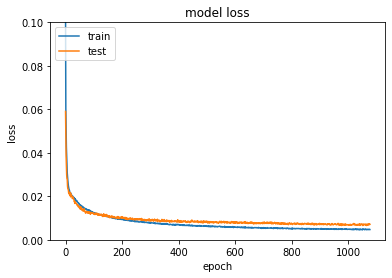

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0, 0.1])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                2240      
_________________________________________________________________
activation_1 (Activation)    (None, 80)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
activation_2 (Activation)    (None, 40)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 40)               

In [26]:
# export_model(model, "keras.model.1")

In [27]:
# # serialize model to JSON
# model_json = model.to_json()
# with open("model_1.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model_1.h5")
# print("Saved model to disk")

In [28]:
# y_train = scaler.inverse_transform(y_train)
# y_test = scaler.inverse_transform(y_test)
# y = scaler.inverse_transform(y)

In [29]:
y_train_hat = model.predict(x_train)
# y_train_hat = scaler.inverse_transform(y_train_hat)


y_test_hat = model.predict(x_test)
# y_test_hat = scaler.inverse_transform(y_test_hat)


y_hat = model.predict(x)
# y_hat = scaler.inverse_transform(y_hat)

In [30]:
# y_train, y_train_hat = np.exp(y_train), np.exp(y_train_hat)
# y_test, y_test_hat = np.exp(y_test), np.exp(y_test_hat)
# y, y_hat = np.exp(y), np.exp(y_hat)

In [31]:
mse_train = mean_squared_error(y_train, y_train_hat)
mse_test = mean_squared_error(y_test, y_test_hat)
mse_all = mean_squared_error(y, y_hat)

print(np.sqrt(mse_train))
print(np.sqrt(mse_test))
print(np.sqrt(mse_all))

0.05168025961374661
0.0841847524612131
0.054108142101666645


In [32]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [33]:
mape_train = mean_absolute_percentage_error(y_train, y_train_hat)
mape_test = mean_absolute_percentage_error(y_test, y_test_hat)
mape_all = mean_absolute_percentage_error(y, y_hat)

print(mape_train)
print(mape_test)
print(mape_all)

12.420571868266304
21.518994527613753
12.949724304541046


In [34]:
# for i in range(len(y_test)):
#   print(y_test[i], y_test_hat[i])

/Users/mingfei/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


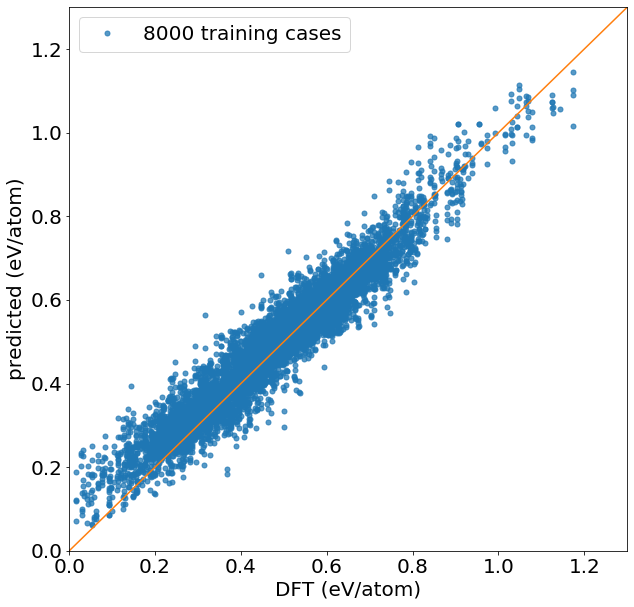

In [58]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(y_train, y_train_hat, marker='o', linestyle='', ms=5, alpha=0.75, label=str(len(y_train))+" training cases")
ax.plot(np.linspace(.0, 1.3, num=1000), np.linspace(.0, 1.3, num=1000))
ax.legend(prop={'size': 20})
plt.xlim([0.0, 1.3])
plt.ylim([0.0, 1.3])
plt.xlabel("DFT (eV/atom)", size=20)
plt.ylabel("predicted (eV/atom)", size=20)

ax.tick_params(axis='both', which='major', labelsize=20)
#plt.close()
fig.show()
fig.savefig("training.png")

/Users/mingfei/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


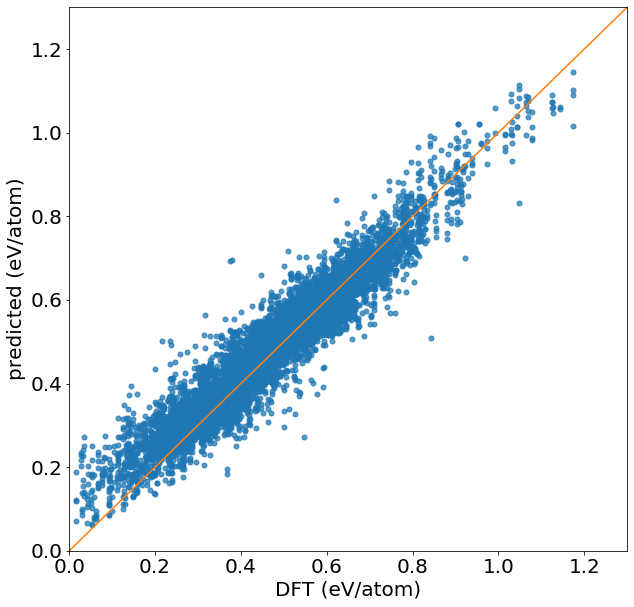

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(y, y_hat, marker='o', linestyle='', ms=5, alpha=0.75, label='_nolabel_')
ax.plot(np.linspace(.0, 1.3, num=1000), np.linspace(.0, 1.3, num=1000))
# ax.legend(prop={'size': 20})
plt.xlim([0.0, 1.3])
plt.ylim([0.0, 1.3])
plt.xlabel("DFT (eV/atom)", size=20)
plt.ylabel("predicted (eV/atom)", size=20)
ax.tick_params(axis='both', which='major', labelsize=20)


fig.show()
fig.savefig("total.png")

/Users/mingfei/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


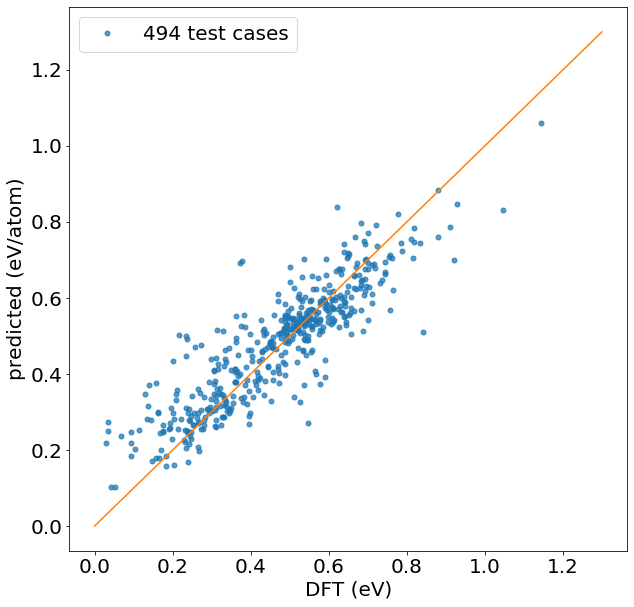

In [89]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(y_test, y_test_hat, marker='o', linestyle='', ms=5, alpha=0.75, label=str(len(y_test))+" test cases")
ax.plot(np.linspace(.0, 1.3, num=1000), np.linspace(.0, 1.3, num=1000))
ax.legend(prop={'size': 20})
ax.set_xlabel("DFT (eV)", size=20)
plt.ylabel("predicted (eV/atom)", size=20)
ax.tick_params(axis='both', which='major', labelsize=20)
# plt.xlim([0.1, 0.95])
# plt.ylim([0.1, 0.95])
fig.show()

In [38]:
y_ver_hat = model.predict(x_ver)
# y_ver_hat = np.exp(y_ver_hat)
# y_ver_hat = scaler.inverse_transform(y_ver_hat)
mse_ver = mean_squared_error(y_ver, y_ver_hat)
print(np.sqrt(mse_ver))
mape_ver = mean_absolute_percentage_error(y_ver, y_ver_hat)
print(mape_ver)

0.04385290065958955
6.769663520805623


/Users/mingfei/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


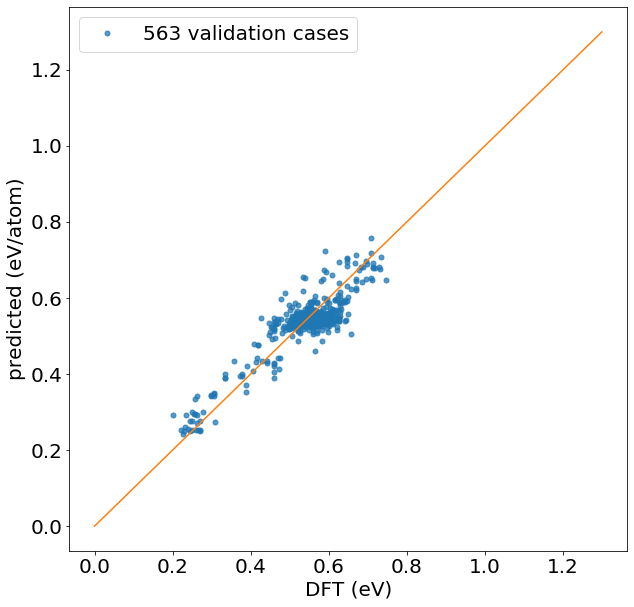

In [55]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(y_ver, y_ver_hat, marker='o', linestyle='', ms=5, alpha=0.75, label=str(len(y_ver))+" validation cases")
ax.plot(np.linspace(.0, 1.3, num=1000), np.linspace(.0, 1.3, num=1000))

ax.legend(prop={'size': 20})
ax.set_xlabel("DFT (eV)", size=20)
ax.set_ylabel("predicted (eV/atom)", size=20)
ax.tick_params(axis='both', which='major', labelsize=20)


# plt.xlim([0.1, 0.95])
# plt.ylim([0.1, 0.95])
fig.show()

In [40]:
a = np.asarray([[1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 4.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 3.0]])

In [41]:
model.predict(a)

array([[0.6245317]], dtype=float32)

In [42]:
# from keras.utils import plot_model
# plot_model(model, to_file='visual_model.png')

In [43]:
df1_order = pd.read_pickle('/Users/mingfei/Softwares/KNN2/prod/ordered_1/encode_save.pd')

In [44]:
# df_ver['Al_conc'] = df_ver.apply(lambda row : get_conc(row, 0), axis=1)
# df_ver['Mg_conc'] = df_ver.apply(lambda row : get_conc(row, 1), axis=1)
# df_ver['Zn_conc'] = df_ver.apply(lambda row : get_conc(row, 2), axis=1)
# df_ver['Vac_conc'] = df_ver.apply(lambda row : get_conc(row, 3), axis=1)

df1_order['encode'] = df1_order.apply (lambda row: getOneHotEncoding(row), axis=1)
df1_order = df1_order[["config", "neb", "encode", "E_barr", "type_x"]]

df1_order = df1_order[df1_order['E_barr'] > lower]
df1_order = df1_order[df1_order['E_barr'] < upper]

x_ver_ord, y_ver_ord = np.stack(df1_order["encode"]), np.array(df1_order["E_barr"]).reshape(-1, 1)

In [45]:
y_ver_ord_hat = model.predict(x_ver_ord)
mse_ver = mean_squared_error(y_ver_ord, y_ver_ord_hat)
print(np.sqrt(mse_ver))
mape_ver = mean_absolute_percentage_error(y_ver_ord, y_ver_ord_hat)
print(mape_ver)

0.04855795984762735
9.383498498117362


/Users/mingfei/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


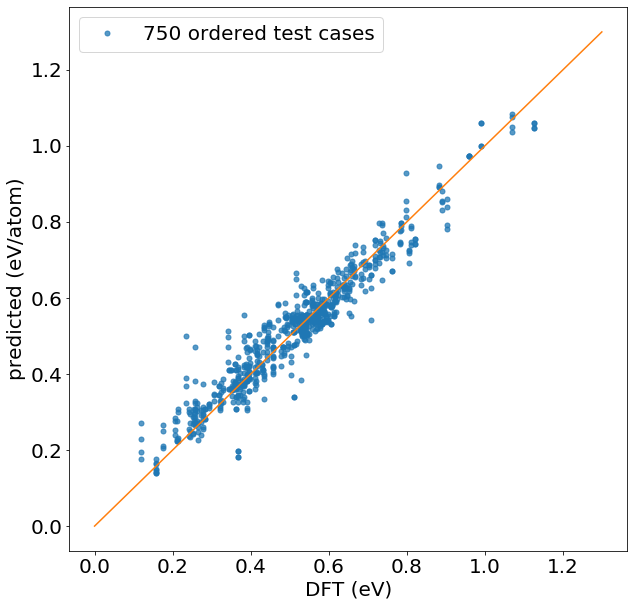

In [60]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(y_ver_ord[:750], y_ver_ord_hat[:750], marker='o', linestyle='', ms=5, alpha=0.75, label=str(len(y_ver_ord[:750]))+" ordered test cases")
ax.plot(np.linspace(.0, 1.3, num=1000), np.linspace(.0, 1.3, num=1000))
ax.legend(prop={'size': 20})
ax.set_xlabel("DFT (eV)", size=20)
ax.set_ylabel("predicted (eV/atom)", size=20)
ax.tick_params(axis='both', which='major', labelsize=20)
# plt.xlim([0.1, 0.95])
# plt.ylim([0.1, 0.95])
fig.show()
fig.savefig("fit_ordered.png")

In [47]:
# df1_order_below_02 = df1_order[df1_order['E_barr'] < 0.2]

In [48]:
# df1_order_below_02